<a href="https://colab.research.google.com/github/plklinh/ECON_599_Team_1/blob/master/Tune_FB_Prophet_Reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objects as go
import pickle
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
#from fbprophet.serialize import model_to_json, model_from_json
import json
from sklearn import metrics

ModuleNotFoundError: No module named 'fbprophet.serialize'

In [22]:
# Reading in data
data = pd.read_csv("msa_merged_data.csv")
data["BEGIN_DATE_GMT"] = pd.to_datetime(data["BEGIN_DATE_GMT"])

In [32]:
# Functions to make FBProphet Datasets
def make_prophet_df(X, y, regressors):
    data = pd.DataFrame()
    data["y"] = y
    data['ds'] = X["BEGIN_DATE_GMT"]
    for i in regressors:
        data[i] = X[i]
    return data

def make_future_df(prophet_model, df_train, df_test,include_history):
    # Creating the dataframe with datetime values to predict on (making predictions on train as well as the test set)
    future_dates = prophet_model.make_future_dataframe(periods=len(df_test), freq='H', include_history= include_history)
    # Adding regressors 
    if include_history:
        future_dates = pd.merge(future_dates, (df_train.append(df_test)).drop('y', axis=1), on = 'ds')
    else:
        future_dates = pd.merge(future_dates, df_test.drop('y', axis=1), on = 'ds')

    return future_dates

# X-y split
y = data["AIL_DEMAND"]
X = data.drop(columns = ["AIL_DEMAND"])
            
# Making Lags
# Choose Regressors
#X["Weighted_Avg_Temp.1_hour_lag"] = X["Weighted_Avg_Temp"].shift(1)
#regressors = ["Weighted_Avg_Temp.1_hour_lag", "workingday"]
X["Calgary_temp.1_hour_lag"]=X["Calgary_temp"].shift(1)
X["Edmonton_temp.1_hour_lag"]=X["Edmonton_temp"].shift(1)
X["FortMM_temp.1_hour_lag"]=X["FortMM_Temp"].shift(1)
X["Lethbridge_temp.1_hour_lag"]=X["Lethbridge_temp"].shift(1)
regressors = ["Calgary_temp.1_hour_lag","Edmonton_temp.1_hour_lag","FortMM_temp.1_hour_lag","Lethbridge_temp.1_hour_lag","future 1","WTI spot","workingday"]

# Spliting train and test set
split_index = data[data["BEGIN_DATE_GMT"] ==  "2020-01-01 00:00:00"].index[0]
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Making Prophet dataset
prop_train = make_prophet_df(X_train, y_train, regressors)
prop_train = prop_train.dropna().reindex()

# Final model using all of test set
# Prophet model
prophet_model = Prophet(growth='linear', interval_width = 0.95, 
                yearly_seasonality=True,
                weekly_seasonality='auto',
                daily_seasonality='auto',
                seasonality_mode='additive')

# Adding regressors
# Continous vars
prophet_model.add_regressor(regressors[0], 
                            #prior_scale=20, 
                            mode='additive', 
                            standardize=False)
prophet_model.add_regressor(regressors[1],
                           #prior_scale=20,
                           mode='additive',
                           standardize=False)
prophet_model.add_regressor(regressors[2],
                           #prior_scale=20,
                           mode='additive',
                           standardize=False)
prophet_model.add_regressor(regressors[3],
                           #prior_scale=20,
                           mode='additive',
                           standardize=False)
prophet_model.add_regressor(regressors[4],
                           #prior_scale=10
                           mode='additive',
                           standardize=False)
prophet_model.add_regressor(regressors[5],
                           #prior_scale=10,
                            mode='additive',
                            standardize=False)

# Binary vars  
prophet_model.add_regressor(regressors[6], 
                    #prior_scale=10, 
                    mode='additive', 
                    standardize='auto') 

# Fit model
prophet_model.fit(prop_train)

# Predicting the future
prop_test = make_prophet_df(X_test, y_test, regressors)

# Creating the dataframe with datetime values to predict on (making predictions on train as well as the test set)
future_dates = make_future_df(prophet_model, prop_test, prop_train, 
                            include_history=True)

test_forecast = prophet_model.predict(future_dates)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [16]:
# Calculating performance metrics

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

ev_train = metrics.explained_variance_score( prop_train["y"], test_forecast[ test_forecast["ds"] < "2020-01-01 00:00:00" ]["yhat"]) * 100
mape_train = mean_absolute_percentage_error( prop_train["y"], test_forecast[ test_forecast["ds"] < "2020-01-01 00:00:00" ]["yhat"]) *100

ev_test = metrics.explained_variance_score( prop_test["y"], test_forecast[  test_forecast["ds"] >= "2020-01-01 00:00:00" ]["yhat"]) * 100
mape_test = mean_absolute_percentage_error( prop_test["y"], test_forecast[  test_forecast["ds"] >= "2020-01-01 00:00:00" ]["yhat"]) *100

pd.DataFrame({"Data":["train", "test"],
              "Explained Variance":[ev_train,ev_test] ,
              "Mean Aboslute Perc. Error": [mape_train, mape_test]})

,Data,Explained Variance,Mean Aboslute Perc. Error
0,train,91.673097,2.312739
1,test,83.168701,3.502148


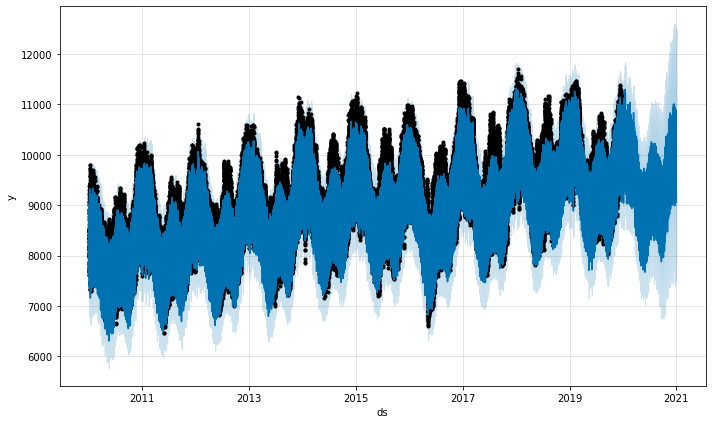

In [30]:
# Predicted values for entire period from 2010 - 2020
_ = prophet_model.plot(test_forecast)

In [45]:
# Hour by Hour predicted Values for 2020
fig = go.Figure()
fig.add_trace(go.Scatter(
            x= test_forecast[test_forecast["ds"] >= "2020-01-01 00:00:00" ]["ds"],
            y= test_forecast[test_forecast["ds"] >= "2020-01-01 00:00:00" ]["yhat_lower"],
            mode='lines', 
            line_color='#00CC96', name = "Lower band"
            ))

fig.add_trace(go.Scatter(
            x= test_forecast[test_forecast["ds"] >= "2020-01-01 00:00:00" ]["ds"],
            y= test_forecast[test_forecast["ds"] >= "2020-01-01 00:00:00" ]["yhat_upper"],
            fill='tonexty', 
            mode='lines', 
            line_color='#00CC96', name = "Upper band"
            ))

fig.add_trace(go.Scatter(x=prop_test["ds"], y=prop_test["y"],
                        mode='lines',
                        line_color = "black",
                        name = "Actual"
                        ))

fig.add_trace(go.Scatter( x= test_forecast[test_forecast["ds"] >= "2020-01-01 00:00:00" ]["ds"],
                y= test_forecast[test_forecast["ds"] >= "2020-01-01 00:00:00" ]["yhat"],
                mode='lines',
                line_color = "indianred",
                name= "Predicted"))
                
fig.update_xaxes(title_text="Time")
fig.update_yaxes(title_text="AIL Demand")
fig.update_layout(title='Predicted 2020 Load using 1-hour ahead weighted temperature')

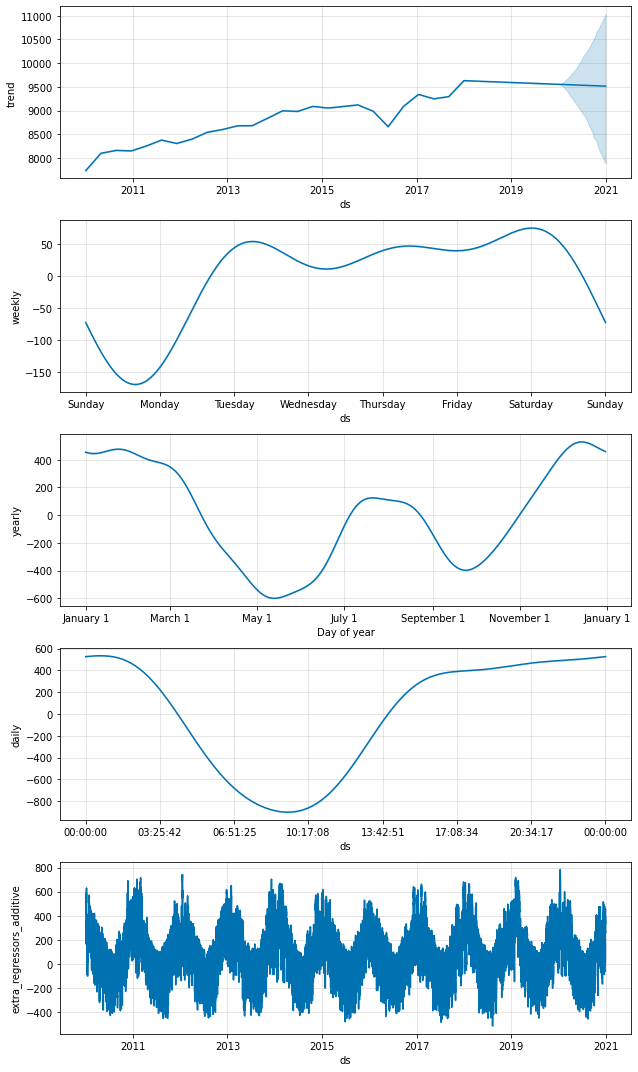

In [21]:
# Predicted Time trends for 2020
_ = prophet_model.plot_components(test_forecast)

In [4]:
import json
from fbprophet.serialize import model_to_json, model_from_json

with open('initial_prophet_model.json', 'w') as fout:
    json.dump(model_to_json(prophet_model), fout)  # Save model